# Multiclass Classification – Improved

This notebook improves multiclass performance with:
- Class balance checks and SMOTE oversampling
- Multiple models: Logistic Regression, Random Forest, XGBoost
- Hyperparameter tuning with GridSearchCV (F1-macro)
- Clean evaluation (macro F1, report, confusion matrix)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# XGBoost is optional; comment out if not installed
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception as e:
    print('XGBoost not available:', e)
    HAS_XGB = False

np.random.seed(42)

In [2]:
# Generate synthetic but *learnable* dataset
n = 900
age = np.random.randint(18, 70, n)
income = np.random.randint(20000, 120000, n)
gender = np.random.choice(['Male','Female'], n)
region = np.random.choice(['North','South','East','West'], n)
purchases = np.random.poisson(5, n)

# Create a target with some relation to features to make learning possible
# segment: 0,1,2
logits = (
    0.00003 * income
    + 0.05 * (purchases)
    + 0.02 * (age - age.mean())
    + (gender == 'Female') * 0.2
)
# Map logits + region to 3 classes to create structure
score = logits + np.select(
    [
        region == 'North',
        region == 'South',
        region == 'East',
        region == 'West'
    ],
    [0.3, -0.2, 0.1, -0.1],
    default=0.0
)

# Convert score into 3 classes by tertiles
q1, q2 = np.quantile(score, [1/3, 2/3])
segment = np.where(score < q1, 0, np.where(score < q2, 1, 2))

df = pd.DataFrame({
    'id': range(1, n+1),
    'age': age,
    'income': income,
    'gender': gender,
    'region': region,
    'purchases': purchases,
    'segment': segment
})

# Introduce some nulls
for col in ['income','gender']:
    idx = np.random.choice(df.index, size=int(0.07*n), replace=False)
    df.loc[idx, col] = np.nan

df.to_csv('multiclass_data_with_nulls.csv', index=False)
print('Saved CSV: multiclass_data_with_nulls.csv')
df.head()

Saved CSV: multiclass_data_with_nulls.csv


,id,age,income,gender,region,purchases,segment
0,1,56,63088.0,Male,East,6,1
1,2,69,59811.0,Male,North,5,1
2,3,46,75479.0,Female,East,3,1
3,4,32,105392.0,Female,West,2,2
4,5,60,107369.0,Male,South,6,2


In [3]:
# Impute nulls (simple strategy)
df['income'] = df['income'].fillna(df['income'].median())
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

# Quick check of class distribution
print('Class distribution (segment):')
print(df['segment'].value_counts(normalize=True).sort_index())

Class distribution (segment):
segment
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64


In [4]:
# Features / target
X = df.drop(columns=['id','segment'])
y = df['segment']

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (720, 5) Test size: (180, 5)


In [5]:
# Preprocessing: One-Hot Encode categoricals, pass through numerics
categorical = ['gender','region']
numeric = ['age','income','purchases']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)

In [6]:
# Apply SMOTE on the preprocessed numeric-only arrays:
# We need to transform X_train first to numeric space for SMOTE
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)

print('After SMOTE class counts:')
print(pd.Series(y_train_res).value_counts())

After SMOTE class counts:
segment
2    240
1    240
0    240
Name: count, dtype: int64


In [7]:
def evaluate_model(name, model, X_te, y_te):
    y_pred = model.predict(X_te)
    macro_f1 = f1_score(y_te, y_pred, average='macro')
    print(f'\n=== {name} ===')
    print('Macro F1:', round(macro_f1, 4))
    print(classification_report(y_te, y_pred))
    cm = confusion_matrix(y_te, y_pred)
    # Plot confusion matrix with matplotlib only
    fig = plt.figure(figsize=(5,4))
    plt.imshow(cm)
    plt.title(f'Confusion Matrix – {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, str(val), ha='center', va='center')
    plt.tight_layout()
    plt.show()
    return macro_f1


=== Logistic Regression ===
Macro F1: 0.845
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        60
           1       0.76      0.78      0.77        60
           2       0.90      0.90      0.90        60

    accuracy                           0.84       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.84      0.84       180



/Users/206793281/Documents/ab/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/206793281/Documents/ab/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


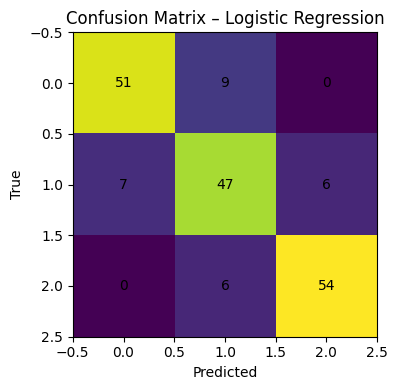

In [8]:
# Baseline: Logistic Regression (multinomial), trained on SMOTE-resampled data
log_reg = LogisticRegression(max_iter=800, multi_class='multinomial')
log_reg.fit(X_train_res, y_train_res)
f1_lr = evaluate_model('Logistic Regression', log_reg, X_test_enc, y_test)


=== Random Forest ===
Macro F1: 0.9057
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        60
           1       0.85      0.87      0.86        60
           2       0.92      0.95      0.93        60

    accuracy                           0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180



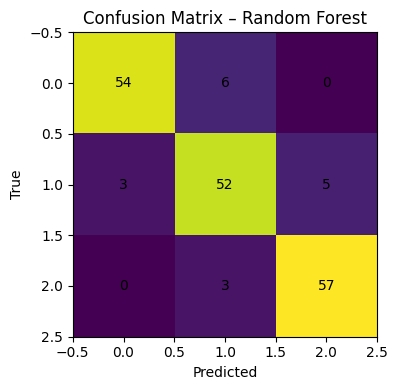

In [9]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced_subsample',
    random_state=42
)
rf.fit(X_train_res, y_train_res)
f1_rf = evaluate_model('Random Forest', rf, X_test_enc, y_test)


=== XGBoost ===
Macro F1: 0.9
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        60
           1       0.87      0.87      0.87        60
           2       0.90      0.93      0.92        60

    accuracy                           0.90       180
   macro avg       0.90      0.90      0.90       180
weighted avg       0.90      0.90      0.90       180



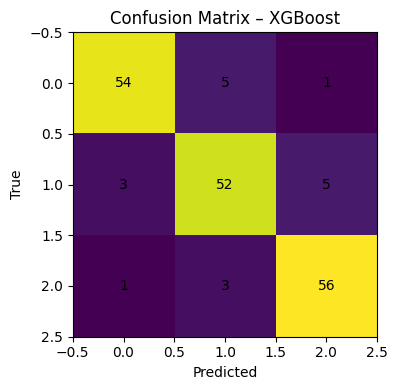

In [10]:
if HAS_XGB:
    xgb = XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        num_class=3,
        n_estimators=400,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    xgb.fit(X_train_res, y_train_res)
    f1_xgb = evaluate_model('XGBoost', xgb, X_test_enc, y_test)
else:
    f1_xgb = None

Best RF params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

=== Random Forest (Tuned) ===
Macro F1: 0.9115
              precision    recall  f1-score   support

           0       0.95      0.92      0.93        60
           1       0.85      0.88      0.87        60
           2       0.93      0.93      0.93        60

    accuracy                           0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180



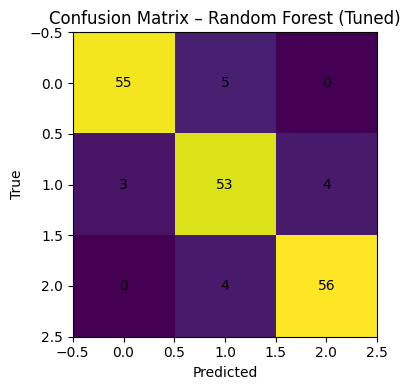

In [11]:
# Hyperparameter tuning (Random Forest) with macro F1
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced_subsample', random_state=42),
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

grid.fit(X_train_res, y_train_res)
best_rf = grid.best_estimator_
print('Best RF params:', grid.best_params_)
f1_rf_tuned = evaluate_model('Random Forest (Tuned)', best_rf, X_test_enc, y_test)

In [12]:
# Compare macro F1s
results = {'LogReg': f1_lr, 'RF': f1_rf, 'RF_tuned': f1_rf_tuned}
if f1_xgb is not None:
    results['XGB'] = f1_xgb
print('\nMacro F1 comparison:', results)


Macro F1 comparison: {'LogReg': 0.8449661943132352, 'RF': 0.9056690949388416, 'RF_tuned': 0.9114630607267452, 'XGB': 0.8999845636133493}
